# Parking Simulator

[Casper Smet](https://github.com/Casper-Smet) & [Stan Meyberg](https://github.com/StanMey)

In this Jupyter Notebook we implement a discrete event system. The goal of this discrete event system is to simulate a garage. Using this simulation, we wish to gain some insight into the inner workings of a parking garage;

-Total income  
-Queue sizes throughout the day  
-Usage of parking spots throughout the day 

The garage we modelled is [Parking garage Gooiland](https://www.centrumparkeren.nl/hilversum/parkeergarages/gooiland).  
Peak times were based off of the neighbouring [supermarket]( https://www.google.com/search?q=albert+heijn+gooialdn&oq=albert+heijn+gooialdn&aqs=chrome..69i57j0l2.13159j0j4&sourceid=chrome&ie=UTF-8).  
Most constants defined in the following section were based off of these two locations.

In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### Declaring constants
Here we declare some constants for running the simulation. To run the simulation with other or changed values simply change the intented constant to the desired value and rerun the simulation.

In [2]:
RANDOM_SEED = 42
SIM_TIME = 24 * 60

# The day hours
DAY_MIN = 8 * 60
DAY_MAX = 18 * 60

# MINUTE rate
MINUTE_RATE = 0.2 / 5

# Max price day
DAY_PRICE = 8
# Max price night
NIGHT_PRICE = 5

# The peak hours
PEAK_MIN = 15 * 60   # 15:00
PEAK_MAX = 20 * 60   # 20:00

# The maximum capacity of the garage
MAX_CAPACITY = 364

# Constants for the amount of time a car is parked
MIN_CAR_PARK_TIME = 1
MAX_CAR_PARK_TIME = 60

# Constants for the time to find a spot
MIN_FINDING_SPOT = 1
MAX_FINDING_SPOT = 5

# Constants for the time to exit the garage
MIN_EXITING_TIME = 1
MAX_EXITING_TIME = 3

# Constants for the range of cars expected per minute outside peak hours
MIN_NON_PEAK_AMOUNT = 0
MAX_NON_PEAK_AMOUNT = 2

# Constants for the range of cars expected per minute inside peak hours
MIN_PEAK_AMOUNT = 1
MAX_PEAK_AMOUNT = 3

## Garage
The Garage class is used for running the simulation and storing the data generated by it. The amount of time spent for each event is normally distributed based on a MIN_- and MAX_ constant. 

This simulation accounts for peak times. It runs for 24 hours in simulation time, each unit of `t` equals one minute.

In [3]:
class Garage(object):
    def __init__(self, env, max_spots=MAX_CAPACITY):
        self.env = env
        self.spots = simpy.Resource(env, max_spots)
        self.taken_spots = []
        self.queue = []
        self.timestamps = []
        
        # Process simulation events
        self.env.process(self.process())
        
    def run(self, until_=SIM_TIME):
        """Runs the simulation"""
        self.env.run(until=until_)
    
    def spots_used(self):
        """Returns tuple with timestamp and amount of taken parking spots"""
        time = self.env.now
        spots = len(self.spots.users)
        self.taken_spots.append((time, spots))
        
    def size_of_queue(self):
        """Returns tuple with timestamp and amount of cars in the queue"""
        time = self.env.now
        queue = len(self.spots.queue)
        self.queue.append((time, queue))
        
        
    def car(self, name):
        """Details behaviour of a car"""
        time_of_arrival = self.env.now

        # Request one of the Garage's parking spots
        print('%s arriving t=%d' % (name, self.env.now))
        with self.spots.request() as req:
            yield req

            time_of_assignment = self.env.now

            # Find spot
            print('%s finding parking spot t=%s' % (name, self.env.now))
            yield self.env.timeout(nrml_dist(MIN_FINDING_SPOT, MAX_FINDING_SPOT))

            # Park car
            print('%s starting to park t=%s' % (name, self.env.now))
            yield self.env.timeout(nrml_dist(MIN_CAR_PARK_TIME, MAX_CAR_PARK_TIME))

            # Leaving garage
            print('%s starting to leave t=%s' % (name, self.env.now))
            yield self.env.timeout(nrml_dist(MIN_EXITING_TIME, MAX_EXITING_TIME))

            # Left garage
            time_of_departure = self.env.now
            print('%s left t=%s' % (name, time_of_departure))

            # Append collected timestamps to self.timestamps
            self.timestamps.append((time_of_arrival, time_of_assignment, time_of_departure))
            
    def process(self):
        """Runs the process in the environment"""
        car_numb = 0
        
        while True:
        
            yield self.env.timeout(1)

            if (PEAK_MIN <= self.env.now <= PEAK_MAX):
                total_new_cars = new_cars_amount(True)
            else:
                total_new_cars = new_cars_amount(False)

            for i in range(total_new_cars):
                self.env.process(self.car(car_numb))
                car_numb += 1
            self.size_of_queue()
            self.spots_used()

Gives a random amount of time spent based on a MIN_- and MAX_- constant, normally distributed.

In [4]:
def nrml_dist(min_, max_):
    """The function takes a minimal and maximal number and generates a number based on normal distribution"""
    mu = (max_ + min_) / 2
    sigma = mu / 3
    
    rd_numb = random.normalvariate(mu, sigma)
    
    if (rd_numb < min_):
        rd_numb = min_
    if (rd_numb > max_):
        rd_numb = max_
    
    return round(rd_numb)

Returns a random amount of time based on point in time.

In [5]:
def new_cars_amount(is_peak):
    """Returns amount of cars based on is_peak"""
    
    total_cars = 0
    
    if is_peak:
        total_cars = nrml_dist(MIN_PEAK_AMOUNT, MAX_PEAK_AMOUNT)
    else:
        total_cars = nrml_dist(MIN_NON_PEAK_AMOUNT, MAX_NON_PEAK_AMOUNT)
        
    return total_cars

Calculates total income based on one car's time of assignment and time of departure.

In [6]:
def calc_price(ToA, ToD):
    """Calculates price based on: ToA: time of assignment, ToD: time of departure"""
    delta_t = abs(ToD - ToA)
    if DAY_MIN < ToA < DAY_MAX: 
    # Price inside the day interval
        price = delta_t * MINUTE_RATE
        if price > DAY_PRICE:
            price = DAY_PRICE
    else:
    # Price outside the day interval
        price = delta_t * MINUTE_RATE
        if price > NIGHT_PRICE:
            price = NIGHT_PRICE
    
    return round(price, 2)

Run simulation, always gives same results due to random seed being set.

In [7]:
# For repeatability of the simulation we choose a random seed
random.seed(RANDOM_SEED)

# Create the environment
env = simpy.Environment()
garage = Garage(env)

# Run the simulation
garage.run()

# Retrieve the generated information during the simulation
data = garage.timestamps
taken_spots = garage.taken_spots
queue_sizes = garage.queue

0 arriving t=1
0 finding parking spot t=1
1 arriving t=2
1 finding parking spot t=2
2 arriving t=3
2 finding parking spot t=3
0 starting to park t=4
3 arriving t=4
4 arriving t=4
3 finding parking spot t=4
4 finding parking spot t=4
1 starting to park t=5
5 arriving t=5
6 arriving t=5
5 finding parking spot t=5
6 finding parking spot t=5
7 arriving t=6
7 finding parking spot t=6
2 starting to park t=7
3 starting to park t=7
8 arriving t=7
8 finding parking spot t=7
4 starting to park t=8
6 starting to park t=8
9 arriving t=8
9 finding parking spot t=8
8 starting to park t=9
10 arriving t=9
9 starting to park t=9
10 finding parking spot t=9
5 starting to park t=10
7 starting to park t=10
11 arriving t=10
11 finding parking spot t=10
12 arriving t=11
12 finding parking spot t=11
10 starting to park t=13
11 starting to park t=13
13 arriving t=13
13 finding parking spot t=13
12 starting to park t=14
13 starting to park t=15
14 arriving t=15
14 finding parking spot t=15
15 arriving t=16
15 

437 starting to leave t=474
445 starting to leave t=474
467 starting to park t=474
469 arriving t=474
469 finding parking spot t=474
470 arriving t=475
470 finding parking spot t=475
451 starting to leave t=476
434 left t=476
445 left t=476
469 starting to park t=476
471 arriving t=476
471 finding parking spot t=476
438 starting to leave t=477
468 starting to park t=477
437 left t=477
472 arriving t=477
472 finding parking spot t=477
451 left t=478
473 arriving t=478
473 finding parking spot t=478
435 starting to leave t=479
452 starting to leave t=479
470 starting to park t=479
474 arriving t=479
475 arriving t=479
474 finding parking spot t=479
475 finding parking spot t=479
471 starting to park t=480
438 left t=480
435 left t=480
476 arriving t=480
475 starting to park t=480
476 finding parking spot t=480
472 starting to park t=481
473 starting to park t=481
477 arriving t=481
477 finding parking spot t=481
429 starting to leave t=482
453 starting to leave t=482
452 left t=482
478 a

751 finding parking spot t=756
707 starting to leave t=757
748 starting to park t=757
749 starting to park t=757
723 left t=757
752 arriving t=757
751 starting to park t=757
752 finding parking spot t=757
710 left t=758
724 left t=758
753 arriving t=758
753 finding parking spot t=758
706 starting to leave t=759
750 starting to park t=759
754 arriving t=759
754 finding parking spot t=759
707 left t=760
752 starting to park t=760
755 arriving t=760
755 finding parking spot t=760
753 starting to park t=761
706 left t=761
756 arriving t=761
756 finding parking spot t=761
712 starting to leave t=762
728 starting to leave t=762
757 arriving t=762
757 finding parking spot t=762
742 starting to leave t=763
754 starting to park t=763
758 arriving t=763
758 finding parking spot t=763
727 starting to leave t=764
745 starting to leave t=764
755 starting to park t=764
712 left t=764
720 starting to leave t=765
733 starting to leave t=765
728 left t=765
757 starting to park t=765
742 left t=765
759 

1085 starting to park t=995
996 left t=995
1040 left t=995
1013 left t=995
1029 left t=995
1090 arriving t=995
1091 arriving t=995
1090 finding parking spot t=995
1091 finding parking spot t=995
979 starting to leave t=996
1059 starting to leave t=996
970 left t=996
1087 starting to park t=996
1088 starting to park t=996
1041 left t=996
1092 arriving t=996
1093 arriving t=996
1092 finding parking spot t=996
1093 finding parking spot t=996
991 starting to leave t=997
1027 starting to leave t=997
1058 starting to leave t=997
1020 left t=997
1089 starting to park t=997
1012 left t=997
1090 starting to park t=997
1091 starting to park t=997
1094 arriving t=997
1095 arriving t=997
1096 arriving t=997
1092 starting to park t=997
1094 finding parking spot t=997
1095 finding parking spot t=997
1096 finding parking spot t=997
979 left t=998
1059 left t=998
1093 starting to park t=998
1097 arriving t=998
1098 arriving t=998
1099 arriving t=998
1097 finding parking spot t=998
1098 finding parking

1417 arriving t=1160
1418 arriving t=1160
1416 starting to park t=1160
1417 finding parking spot t=1160
1418 finding parking spot t=1160
1335 starting to leave t=1161
1336 starting to leave t=1161
1351 starting to leave t=1161
1373 starting to leave t=1161
1408 starting to park t=1161
1337 left t=1161
1349 left t=1161
1414 starting to park t=1161
1419 arriving t=1161
1420 arriving t=1161
1418 starting to park t=1161
1419 finding parking spot t=1161
1420 finding parking spot t=1161
1334 starting to leave t=1162
1362 starting to leave t=1162
1363 starting to leave t=1162
1413 starting to park t=1162
1335 left t=1162
1336 left t=1162
1373 left t=1162
1421 arriving t=1162
1422 arriving t=1162
1423 arriving t=1162
1421 finding parking spot t=1162
1422 finding parking spot t=1162
1423 finding parking spot t=1162
1411 starting to park t=1163
1415 starting to park t=1163
1351 left t=1163
1362 left t=1163
1424 arriving t=1163
1424 finding parking spot t=1163
1350 starting to leave t=1164
1369 s

## Analysing the simulation

In [8]:
received_money = list(map(lambda x : calc_price(x[1], x[2]), data))
print("total money received: {0}".format(round(sum(received_money), 2)))

total money received: 2423.76


In [9]:
car_waiting_time = list(map(lambda x : abs(x[1] - x[0]), data))
print("Average waiting time: {0}".format(np.mean(car_waiting_time)))

Average waiting time: 0.0


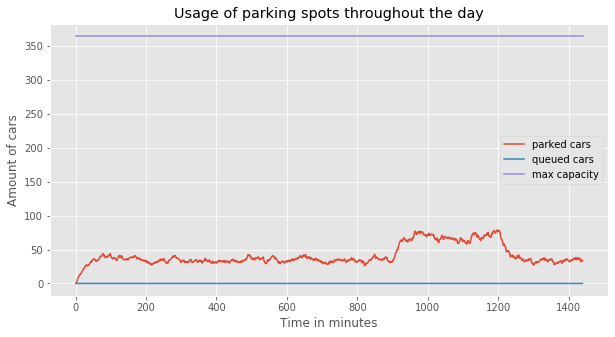

In [10]:
queue = np.array(queue_sizes).T
taken_spots = np.array(taken_spots).T

plt.rcParams['figure.figsize'] = [10,5]

plt.plot(taken_spots[0], taken_spots[1], label="parked cars")
plt.plot(queue[0], queue[1], label="queued cars")
plt.plot([0, SIM_TIME], [MAX_CAPACITY, MAX_CAPACITY], label="max capacity")

plt.title("Usage of parking spots throughout the day")
plt.xlabel("Time in minutes")
plt.ylabel("Amount of cars")

plt.legend()
plt.show()